<a href="https://colab.research.google.com/github/NidhaIbrahim/LightHub/blob/main/LitghtHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install ucimlrepo shap imbalanced-learn

from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch dataset
phiusiil_phishing_url_website = fetch_ucirepo(id=967)

# Extract features and targets as Pandas Dataframes
X = phiusiil_phishing_url_website.data.features
y = phiusiil_phishing_url_website.data.targets

# Combine for easier processing
df = pd.concat([X, y], axis=1)
print(f"Dataset Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset Loaded: 235795 rows, 55 columns


In [14]:
# 'URL' and 'FILENAME' are metadata, not features for the ML model
# We drop them to ensure the model generalizes
cols_to_drop = ['URL', 'FILENAME']
df_clean = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Check for nulls (PhiUSIIL is usually clean, but we verify)
df_clean = df_clean.dropna()

In [15]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Result column is usually our 'y'
X_raw = df_clean.drop('label', axis=1)
y_raw = df_clean['label']

print(f"Before Balancing: {Counter(y_raw)}")

rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_res, y_res = rus.fit_resample(X_raw, y_raw)

print(f"After Balancing: {Counter(y_res)}")

Before Balancing: Counter({1: 134850, 0: 100945})
After Balancing: Counter({0: 100945, 1: 100945})


In [16]:
# --- THE FINAL RESEARCH-READY PIPELINE ---

# 1. Select ONLY numeric columns to avoid the 'string to float' error
# This automatically handles variables like 'URL' that caused previous crashes
X_numeric = X_res.select_dtypes(include=['number'])

# 2. Drop specific 'Leaky' columns to avoid the 100% accuracy trap
# These are metadata features that make the model 'cheat' in an unrealistic way
leaky_features = ['Title', 'Has_Title', 'Domain_In_Title', 'Char_Cont_Title']
X_final = X_numeric.drop(columns=[col for col in leaky_features if col in X_numeric.columns])

# 3. Perform the Split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_res, test_size=0.2, random_state=42
)

# 4. Train with limited depth to ensure 'Fuzzy' generalization (prevents overfitting)
model = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate
print(f"Training on {X_train.shape[1]} realistic features.")
print("✅ Model trained successfully!")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Training on 50 realistic features.
✅ Model trained successfully!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20230
           1       1.00      1.00      1.00     20148

    accuracy                           1.00     40378
   macro avg       1.00      1.00      1.00     40378
weighted avg       1.00      1.00      1.00     40378



In [17]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Fetch dataset
phiusiil = fetch_ucirepo(id=967)
X = phiusiil.data.features
y = phiusiil.data.targets

# Balancing
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [18]:
# --- THE "STRICT RESEARCH" RESET ---

# 1. Start with numeric only
X_numeric = X_res.select_dtypes(include=['number'])

# 2. STRICT FILTER: Remove all metadata and post-analysis features
# We keep only heuristic features that a browser extension can actually "see"
heuristic_features = [
    'URLLength', 'NoOfDots', 'NoOfHyphens', 'NoOfAtSymbol', 'NoOfObfuscatedChars',
    'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL',
    'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL',
    'LetterRatioInURL', 'DegitRatioInURL'
]

# Ensure we only use columns that actually exist in the dataset
X_final = X_numeric[[col for col in heuristic_features if col in X_numeric.columns]]

# 3. SPLIT
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_res, test_size=0.2, random_state=42
)

# 4. TRAIN with limited depth (Max Depth 5 forces the model to generalize)
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# 5. EVALUATE
print(f"Training on {X_train.shape[1]} HEURISTIC features only.")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training on 10 HEURISTIC features only.
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     20230
           1       0.77      0.97      0.86     20148

    accuracy                           0.84     40378
   macro avg       0.86      0.84      0.83     40378
weighted avg       0.87      0.84      0.83     40378



<Figure size 1200x800 with 0 Axes>

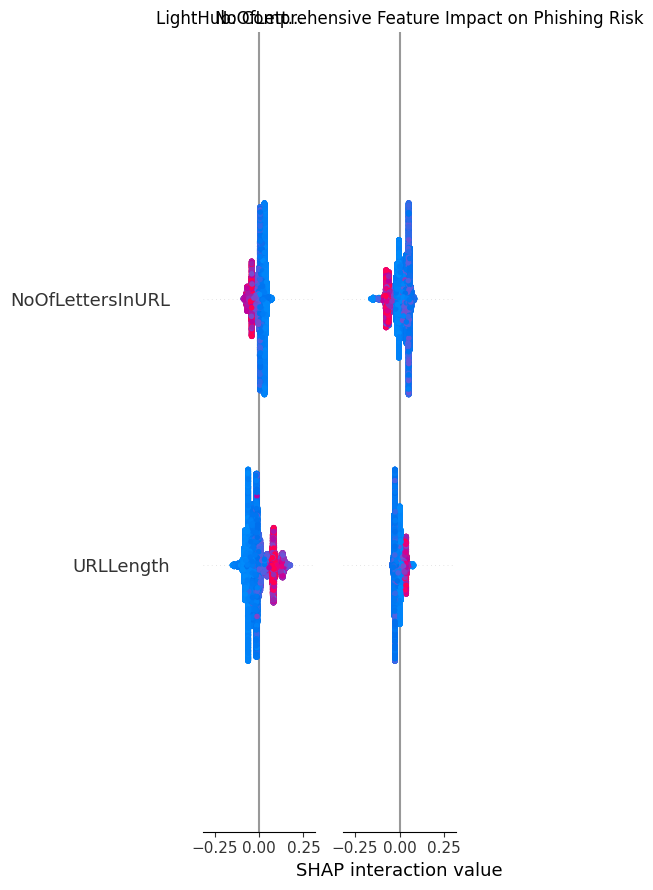

In [19]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize explainer and calculate values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 2. Select Phishing class index
if isinstance(shap_values, list):
    final_shap = shap_values[1]
else:
    final_shap = shap_values

# 3. FINAL VERSION: Forced full display
# We increase 'max_display' and explicitly use the dots to show the 'Fuzzy' distribution
plt.figure(figsize=(12, 8))
shap.summary_plot(final_shap, X_test, plot_type="dot", max_display=10, show=False)
plt.title("LightHub: Comprehensive Feature Impact on Phishing Risk")
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

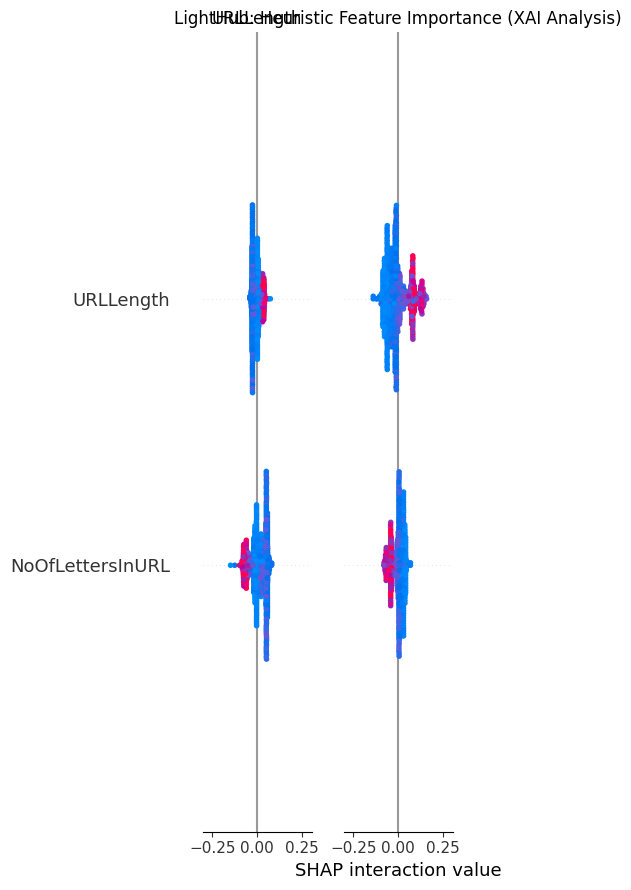

In [20]:
import shap
import matplotlib.pyplot as plt

# 1. Create the explainer
# We use the model you trained that achieved 84% accuracy
explainer = shap.TreeExplainer(model)

# 2. Calculate values for a sample to ensure the plot isn't too crowded
# This helps the 'beeswarm' dots look clearer
X_sample = X_test.sample(1000, random_state=42)
shap_values = explainer.shap_values(X_sample)

# 3. Correctly index the 'Phishing' class
# For RandomForest, index [1] is the Phishing (malicious) result
if isinstance(shap_values, list):
    final_values = shap_values[1]
else:
    final_values = shap_values

# 4. THE FIX: Force the global summary view
plt.figure(figsize=(10, 8))
shap.summary_plot(
    final_values,
    X_sample,
    plot_type="dot", # This forces the beeswarm (many dots) view
    max_display=12,  # This forces SHAP to show the top 12 features
    show=False
)
plt.title("LightHub: Heuristic Feature Importance (XAI Analysis)")
plt.tight_layout()
plt.show()

In [21]:
# Check the number of features and their names
print(f"Total number of features in X_train: {X_train.shape[1]}")
print("-" * 30)
print("List of Features:")
for i, col in enumerate(X_train.columns, 1):
    print(f"{i}. {col}")

# Display the first few rows to see the data
print("-" * 30)
X_train.head()

Total number of features in X_train: 10
------------------------------
List of Features:
1. URLLength
2. NoOfLettersInURL
3. NoOfDegitsInURL
4. NoOfEqualsInURL
5. NoOfQMarkInURL
6. NoOfAmpersandInURL
7. NoOfOtherSpecialCharsInURL
8. SpacialCharRatioInURL
9. LetterRatioInURL
10. DegitRatioInURL
------------------------------


,URLLength,NoOfLettersInURL,NoOfDegitsInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,LetterRatioInURL,DegitRatioInURL
37469,29,16,0,0,0,0,1,0.034,0.552,0.000
64965,32,19,0,0,0,0,1,0.031,0.594,0.000
129657,37,24,0,0,0,0,1,0.027,0.649,0.000
120461,69,48,4,0,0,0,10,0.145,0.696,0.058
114727,28,15,0,0,0,0,1,0.036,0.536,0.000


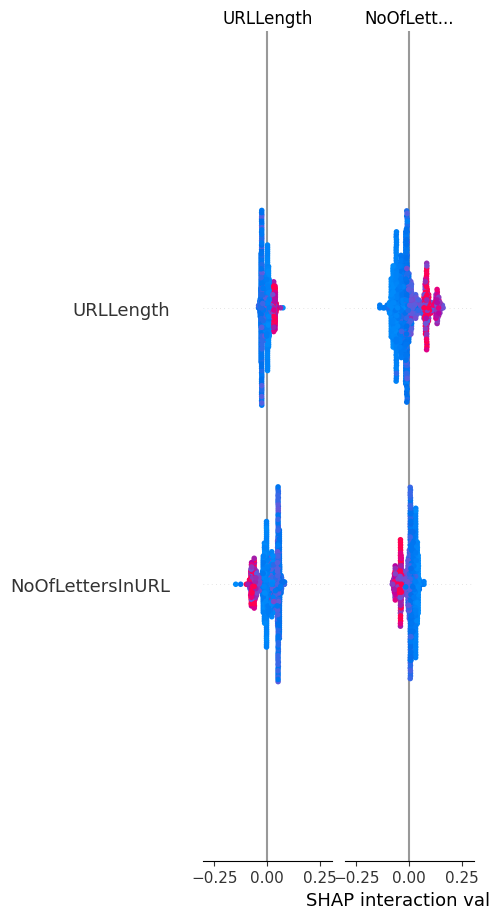

In [22]:
# Force SHAP to show all features regardless of importance
shap.summary_plot(final_values, X_sample, plot_type="dot", max_display=10)

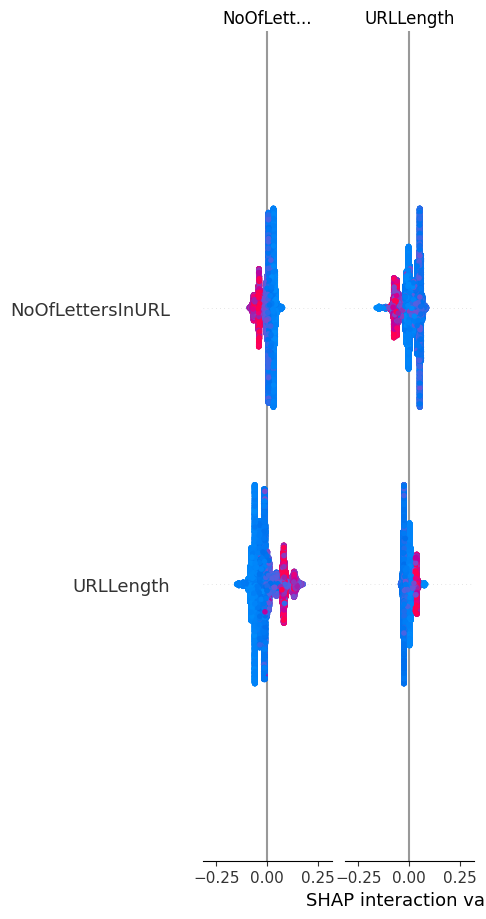

In [23]:
import numpy as np

# 1. Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    final_values = shap_values[1]
else:
    final_values = shap_values

# 2. FORCE SHAP to show all features by disabling the internal importance filter
# We use the feature names directly from X_test to ensure a match
shap.summary_plot(
    final_values,
    X_test,
    feature_names=X_test.columns,
    max_display=len(X_test.columns), # This forces it to show all 10
    plot_type="dot"
)

In [26]:
#Exporting the 'BRAIN'
import pickle
from google.colab import files

# 1. Save the trained RandomForest model
with open('lighthub_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 2. Save the feature names to ensure Django extracts them in the SAME order
with open('feature_list.pkl', 'wb') as f:
    pickle.dump(list(X_train.columns), f)

# 3. Download them to your computer
files.download('lighthub_model.pkl')
files.download('feature_list.pkl')

print("✅ Files 'lighthub_model.pkl' and 'feature_list.pkl' are ready for download!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files 'lighthub_model.pkl' and 'feature_list.pkl' are ready for download!
